In [1]:
# Required libraries
from datetime import datetime
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import matplotlib.dates as mdates
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [2]:
now= datetime.now()

end= datetime(now.year,now.month, now.day) 
start= datetime(now.year-24, now.month, now.day)

In [3]:
stock_data= yf.download("TSLA",start,end)

[*********************100%%**********************]  1 of 1 completed


In [4]:
#Adding a Column for Returns in the DataSet.

#Using the function PctChange from pandas library.

stock_data["Returns"]= stock_data["Close"].pct_change()

In [5]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,NaN
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,-0.002511
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,-0.078473
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,-0.125683
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,-0.160937


<Axes: xlabel='Date'>

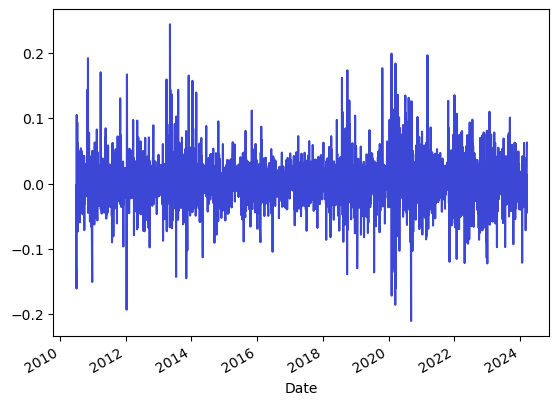

In [6]:
stock_data["Returns"].plot(color="#3c47d6")

<Axes: >

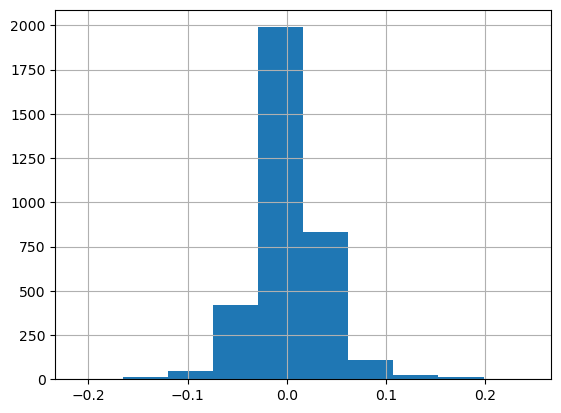

In [7]:
stock_data["Returns"].hist()

In [8]:
# Split data into training (2010-2020) and validation (2020-2023) sets
training_data = stock_data['Returns']['2011-06-29':'2020-03-15']
validation_data = stock_data['Returns']['2020-03-15':'2022-03-15']

# Use 'Adj Close' prices as the stock price for training
training_set = training_data.values.reshape(-1, 1)
validation_set = validation_data.values.reshape(-1, 1)

In [9]:
training_set=training_set[1:]

In [10]:
# Feature scaling using Standardization

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
validation_set_scaled = sc.transform(validation_set)

In [14]:
# Creating input sequences for training
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(training_set_scaled)
X_validation, y_validation = create_sequences(validation_set_scaled)

# Reshape inputs for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))

X_train.shape

(2130, 60, 1)

In [16]:
X_train

array([[[ 0.85235592],
        [-0.17338166],
        [ 0.06907696],
        ...,
        [-0.24618959],
        [-0.31847493],
        [ 0.83917984]],

       [[-0.17338166],
        [ 0.06907696],
        [-0.24696816],
        ...,
        [-0.31847493],
        [ 0.83917984],
        [-1.05679919]],

       [[ 0.06907696],
        [-0.24696816],
        [ 0.75721661],
        ...,
        [ 0.83917984],
        [-1.05679919],
        [ 0.74697801]],

       ...,

       [[ 0.54887315],
        [-0.16757192],
        [ 1.91860324],
        ...,
        [-0.94848683],
        [-4.21734297],
        [ 1.82406331]],

       [[-0.16757192],
        [ 1.91860324],
        [-0.25929384],
        ...,
        [-4.21734297],
        [ 1.82406331],
        [-0.58481162]],

       [[ 1.91860324],
        [-0.25929384],
        [ 1.08742282],
        ...,
        [ 1.82406331],
        [-0.58481162],
        [-3.61809049]]])

In [12]:
# Building the LSTM Model
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=1))

In [13]:
# Compiling the LSTM Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the Model and store history
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 1.0107 - val_loss: 1.6531
Epoch 2/100


KeyboardInterrupt: 

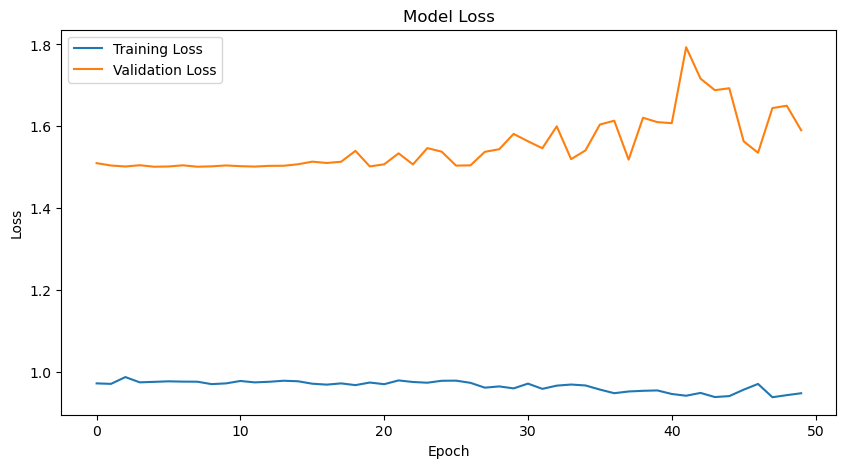

In [159]:
# Plot loss and accuracy during training
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [160]:
# Download test data for SPY from Yahoo Finance 
#Or we could've used our downloaded dataset but we are lazy.
stock_test = yf.download('TSLA', start='2022-03-15', end='2024-03-15')


stock_test["Returns"]= stock_test["Close"].pct_change()

# Use 'Adj Close' prices as the test data
real_stock_price = stock_test['Returns'].values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed


In [161]:
# Preparing Test Data and Generating Predictions
dataset_total = pd.concat((stock_data['Returns'], stock_test['Returns']), axis=0)
inputs = dataset_total[len(dataset_total) - len(stock_test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Making Predictions
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


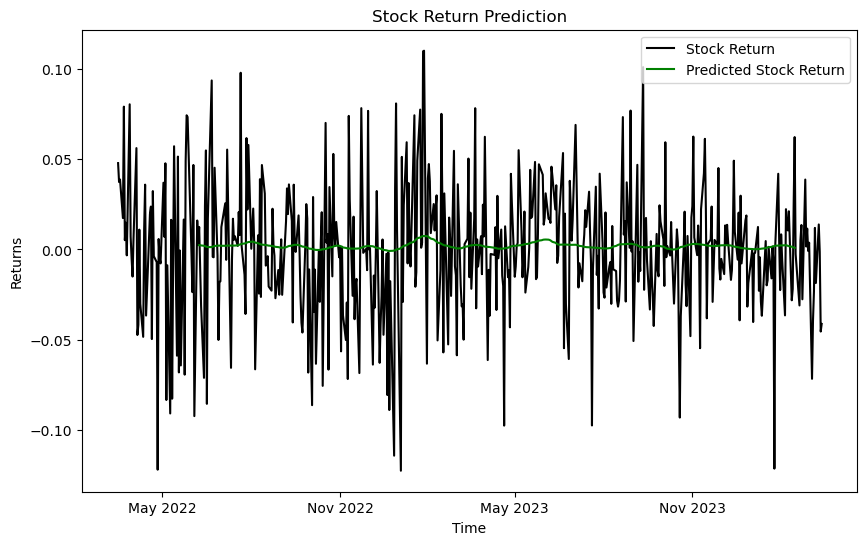

In [162]:
# Prepare dates for the predicted stock prices
date_range = pd.date_range(start='2022-03-15', periods=len(predicted_stock_price), freq='B')  # 'B' business day frequency

# Visualizing Results with Month and Year on X-axis
plt.figure(figsize=(10, 6))
plt.plot(stock_test.index, real_stock_price, color='black', label='Stock Return')
plt.plot(date_range, predicted_stock_price, color='green', label='Predicted Stock Return')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show tick marks for every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
plt.title('Stock Return Prediction')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()